In [1]:
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, AutoModel
from tqdm.notebook import tqdm
import random
import json

2024-02-09 14:22:51.204386: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-09 14:22:51.245965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
model = AutoModel.from_pretrained("facebook/dinov2-small")
model = model.to("cuda")

In [3]:
target_img = Image.open("./grant-headshot.png")

In [4]:
def get_img_vects(imgs):
    inputs = processor(images=imgs, return_tensors="pt")
    inputs = {k: v.to("cuda") for k, v in inputs.items()}
    outputs = model(**inputs)
    # vects = outputs.last_hidden_state.mean(axis=1).detach().cpu().numpy()
    vects = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
    # normalize
    vects /= np.linalg.norm(vects, axis=1, keepdims=True)
    return vects

In [5]:
target_vect = get_img_vects(target_img)[0]

In [7]:
# Placeholder for the actual batch evaluation function
def batch_evaluate(individuals):
    # print("num individuals = ", len(individuals))
    # Convert individuals to images, process them in a batch, and return their fitness scores
    scores = []
    bs = 64
    for i in tqdm(range(0, len(individuals), bs)):
        batch = individuals[i:i+bs]
        # img = np.array(individual).reshape(img_size, img_size)
        # img = Image.fromarray((img * 255)).resize((224, 224), Image.BOX).convert("RGB")
        imgs = [Image.fromarray((np.array(individual, dtype=np.uint8).reshape(img_size, img_size) * 255)).resize((224, 224), Image.BOX).convert("RGB") for individual in batch]
        # Here, implement the function to convert batch of images to vectors and compare with target vectors
        # For demonstration, this will return a dummy score for each individual
        # scores.extend(((get_img_vects(imgs) - target_vect) ** 2).mean(axis=-1).mean(axis=-1))
        scores.extend(get_img_vects(imgs) @ target_vect)
    
    # print("Scores = ", get_img_vects(imgs).shape)
    return scores

img_size = 32

In [8]:
cadidates = np.load("candidates.npy")

In [12]:
import pandas as pd

In [17]:
str_candidates = []
for x in cadidates:
    str_candidates.append(",".join([str(z) for z in x.flatten().tolist()]))

In [19]:
candidate_df = pd.DataFrame(str_candidates, columns=["candidate"])

In [21]:
candidate_df["index"] = candidate_df.index

In [23]:
candidate_df.drop_duplicates(subset="candidate", inplace=True)

In [27]:
candidate_df["index"].values

array([   0,    1,    2, ..., 6817, 6818, 6819])

In [28]:
cadidates = cadidates[candidate_df["index"].values]

In [29]:
scores = batch_evaluate(cadidates)

  0%|          | 0/35 [00:00<?, ?it/s]

In [30]:
args = np.argsort(scores)

In [37]:
np.save("top_candidates.npy", np.concatenate([cadidates[args[:1000]], ~cadidates[args[:1000]]], axis=0))

In [38]:
import matplotlib.pyplot as plt

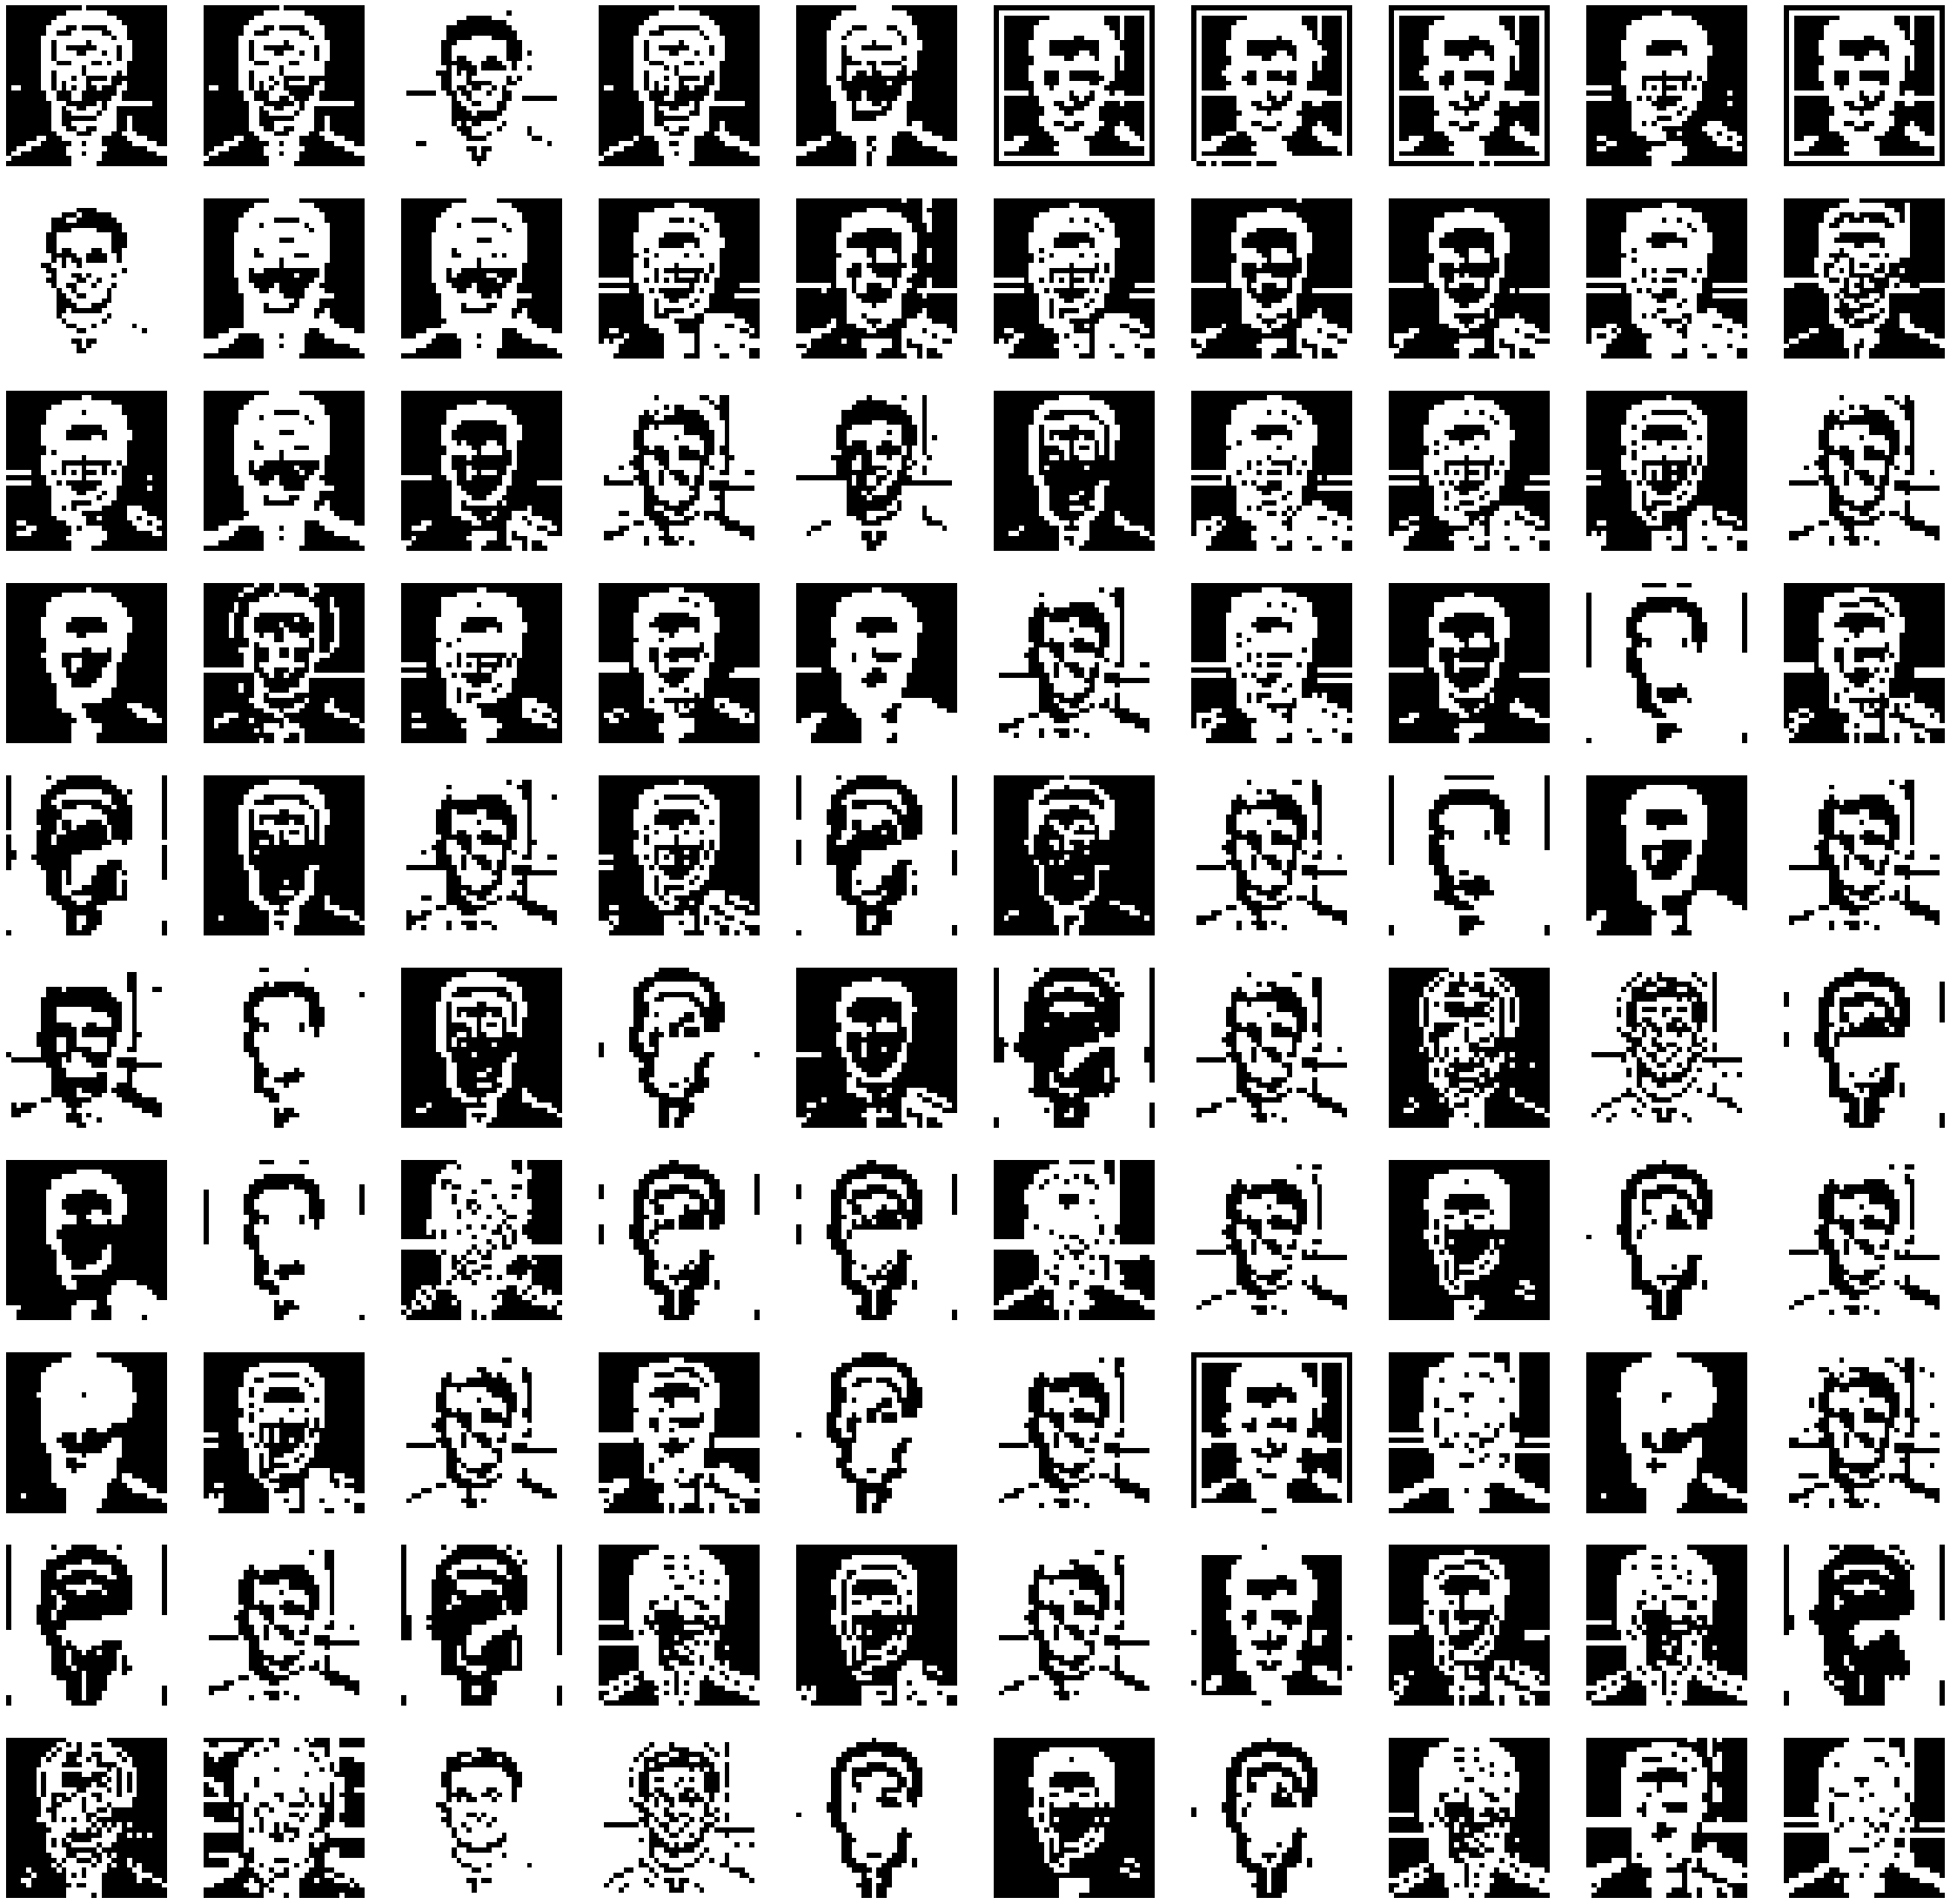

In [39]:

figure, axes = plt.subplots(10, 10, figsize=(40, 40))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(cadidates[args[i]].reshape(img_size, img_size), cmap="gray")
    ax.axis("off")